In [1]:
import circle_packing as cp
import starting_k_grouping as kg
import series_ordering as so
import parallel_plate as pp
import series_plate as sp
import k_grouping_new as gn


from pathlib import Path
from shapely.geometry import Point, Polygon, LineString
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

json_file = "input_json/input_misure.json"  # Path to the input JSON file
out_csv = "out.csv"
R = 9.0  # mm, radius of an 18650 seen from the top
EPS = 0.2          # slack in adjacency threshold    S = 10
P = 12
S=26


[loader] units=mm, px->mm=0.26460, scale_cm_per_px=0.02646
hex grid : 30
after greedy : 30
after compaction : 30
final count : 30


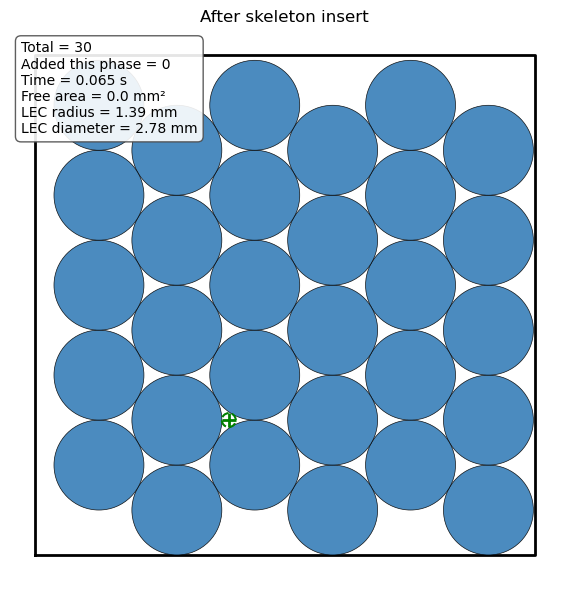

Area that could still host a centre: 640.0 mm²
Largest empty circle radius: 0.70 mm (1.39 mm diameter)
Saved 30 circle centres to out.csv


In [2]:
poly, _, meta = cp.load_boundary(Path(json_file), to_units="mm", require_scale=False)
print(f"[loader] units=mm, px->mm={meta['px_to_mm']:.5f}, scale_cm_per_px={meta['scale_cm_per_px']}")

# 1 ─ aligned hex grid (finer phase scan gives 1-3 extra cells)
centres = cp.best_hex_seed_two_angles(poly, n_phase=16)
print("hex grid :", len(centres))

# pso refine (deleted for now, see below)
#centres1 = pso_refine(centres0, poly)
#print("PSO done")

# 2 ─ first greedy insertion (fills obvious edge gaps)
centres = cp.greedy_insert(poly, centres, trials=1000, max_pass=6)
print("after greedy :", len(centres))

# 3 ─ local compaction (Python re-implementation of Zhou’s batch-BFGS)
centres = cp.batch_bfgs_compact(centres, R, poly, n_pass=4)
print("after compaction :", len(centres))

# 4 ─ second greedy pass (micron pockets now opened by compactor)
centres = cp.greedy_insert(poly, centres, trials=1000, max_pass=3)
print("final count :", len(centres))

prev = len(centres)
t0 = cp.perf_counter()
centres = cp.skeleton_insert(poly, centres, step=2.0)
t1 = cp.perf_counter()
cp.plot_phase(poly, centres, added_idx=np.arange(prev, len(centres)),
        title="After skeleton insert", r=R, time_s=t1 - t0)

# ───▶  DIAGNOSTIC POCKET ANALYSIS  ◀─────────────────────────────────────
free     = poly.buffer(-R).buffer(0)            # safe interior strip
hull     = cp.unary_union([Point(x, y).buffer(R) for x, y in centres])
residual = free.difference(hull)

print(f"Area that could still host a centre: {residual.area:.1f} mm²")

# Optional: largest empty circle (Shapely≥2.0 only)
try:
    from shapely import maximum_inscribed_circle

    rad, centre_pt = cp.largest_empty_circle(residual)
    if rad > 0:
        print(f"Largest empty circle radius: {rad:.2f} mm "
            f"({2*rad:.2f} mm diameter)")
    else:
        print("Residual pocket too thin for even a tiny extra cell.")
except ImportError:
    pass
# ─────────────────────────────────────────────────────────────────────────

# 5 ─ save + preview
np.savetxt(out_csv, centres, delimiter=",", header="x,y", comments="")
print(f"Saved {centres.shape[0]} circle centres to {out_csv}")


Starting CP-SAT solver v9.14.6206
Parameters: random_seed: 0 max_time_in_seconds: 15 log_search_progress: true search_branching: PORTFOLIO_SEARCH cp_model_presolve: true linearization_level: 0 num_search_workers: 6 randomize_search: true cp_model_probing_level: 0 symmetry_level: 2

Initial optimization model '': (model_fingerprint: 0x437d9244c378c08d)
#Variables: 1'909 (#bools: 3 #ints: 4 in objective) (1'605 primary variables)
  - 1'905 Booleans in [0,1]
  - 1 in [0,28]
  - 3 in [0,276]
#kLinear2: 3'010
#kLinear3: 8
#kLinearN: 343 (#terms: 3'569)

Starting presolve at 0.01s
  8.08e-04s  0.00e+00d  [DetectDominanceRelations] 
  7.96e-03s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  5.89e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=340 #potential_subsets=3 
  4.70e-05s  0.00e+00d  [DetectDuplicateColumns] 
  6.80e-05s  0.00e+00d  [DetectDuplicateConstraints] #duplicates=58 
[Symmetry] Graph for symmetry has 5'879 nodes and 12'949 arcs.

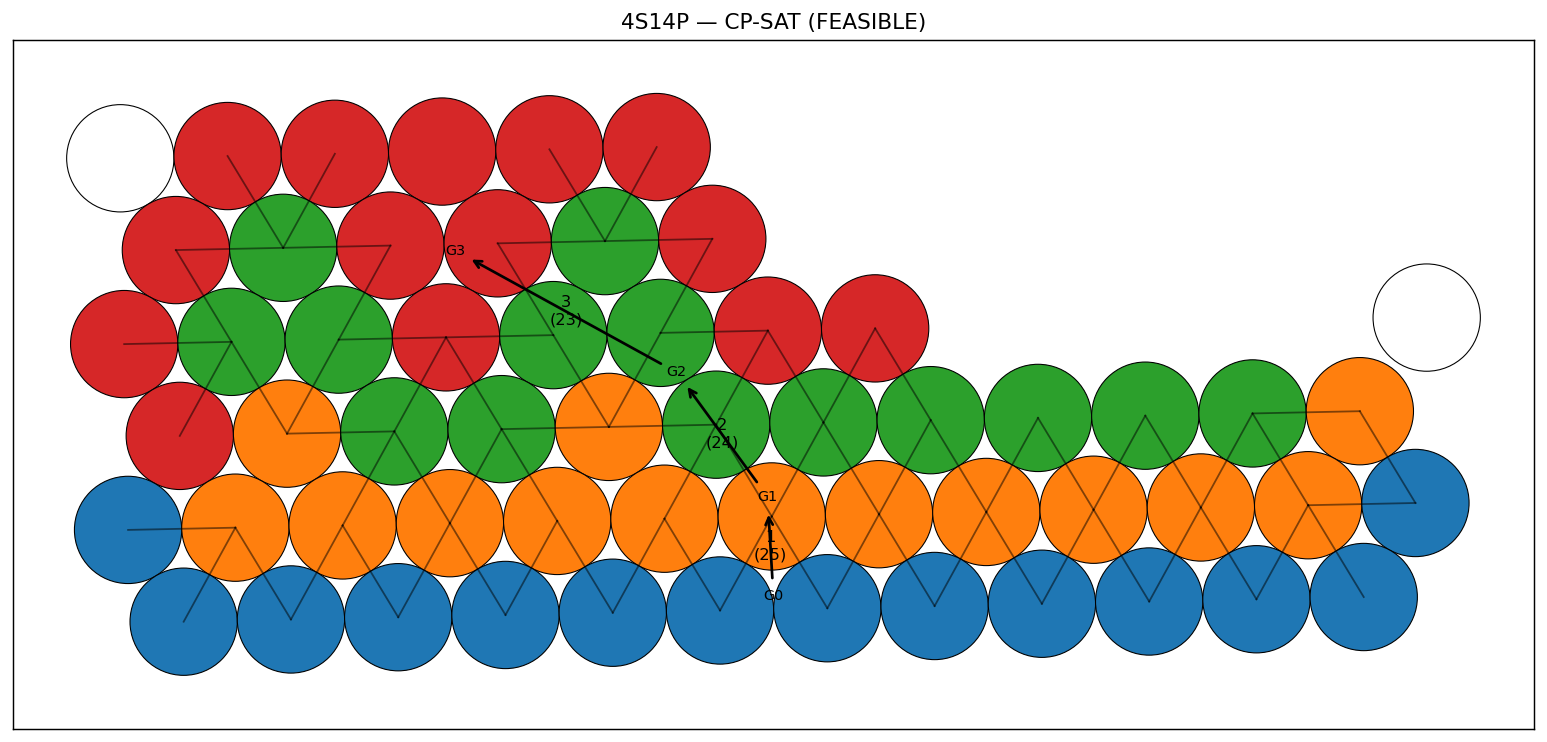

In [ ]:
import battery_layout_cpsat_v2 as bc
import pandas as pd
from ortools.sat.python import cp_model


csv = "out.csv"
S = 6
P = 5
radius = 9.0
tol = 2
time_budget = 60
degree_cap = 6
enforce_degree = False
target_T=2*P
use_hole_penality=False

df = pd.read_csv(csv)
coords = df[['x','y']].to_numpy()

# tuning senza snake
pack = bc.auto_tune_and_solve(
    coords, S, P, radius, tol,
    time_budget=time_budget,
    target_T=target_T,             
    degree_cap=degree_cap,
    enforce_degree=enforce_degree,
    profiles=("fast","fast","quality"),
    seeds=(0,1,2,3),
    workers=6,
    use_hole_penality=use_hole_penality
)

status, solver, x, r, L, z1, z2, E, T = pack
status_name = {cp_model.OPTIMAL:"OPTIMAL", cp_model.FEASIBLE:"FEASIBLE",
                cp_model.INFEASIBLE:"INFEASIBLE", cp_model.MODEL_INVALID:"MODEL_INVALID",
                cp_model.UNKNOWN:"UNKNOWN"}.get(status, str(status))
print("Solver status:", status_name)

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    links = [int(solver.Value(v)) for v in L]
    tval = solver.Value(T) if T is not None else None
    print(f"min_k Lk = {tval}   sum(L) = {sum(links)}   per-k: {links}")
    bc.plot_solution(
        coords, radius, S, x, z1, z2, E, L, solver,
        title=f"{S}S{P}P — CP-SAT ({status_name})",
        save=None, show_links=True, show_arrows=True
    )
else:
    print("Nessuna soluzione trovata entro il budget.")

In [ ]:
import k_grouping_new as gn
from collections import Counter
import numpy as np
import circle_packing as cp
from pathlib import Path


#json_file = "input_3.json"  # Path to the input JSON file


# 1) load your CSV of centres (x,y)
centres = np.loadtxt("out.csv", delimiter=",", skiprows=1)
poly, _ = cp.load_boundary(Path(json_file))

# 2) infer rows from geometry
R = 9.0
rows = gn.build_rows_from_centres(centres, R)

# 3) choose x,y
x = 40
y = 5

# 1) load centres
centres = np.loadtxt("out.csv", delimiter=",", skiprows=1)  # shape (N,2)
R = 9.0  # your cell radius (mm)

rows = gn.build_rows(centres, R)
rows_sel, info = gn.find_hex_equal_parallelogram(rows, centres, prefer_wide=True)

print(info)  # {'W':…, 'H':…, 'area':…, 'r0':…, 'r1':…, 'd':±1, 's0':…}
gn.plot_hex_parallelogram(centres, R, rows_sel, info)



# 4) group
part_of, groups = gn.group_xSyP_strict_reading(rows_sel, x, y)

# (optional) check
assert len(groups) == x
#assert all(len(g) == y for g in groups)


sizes = Counter(part_of.values())
print("Group sizes:", [sizes[g] for g in sorted(sizes)])
print("Assigned cells:", sum(sizes.values()))
print("Distinct groups used:", len(sizes))

assigned_idx = sorted(part_of.keys())
gn.plot_groups_blockwise(
    centres, part_of, poly,
    R=9.0, S=x, title=f"{x}S{y}P (blockwise)",
    show_labels=True, label_unassigned=False, fontsize=6
)



AttributeError: module 'k_grouping_new' has no attribute 'build_rows'

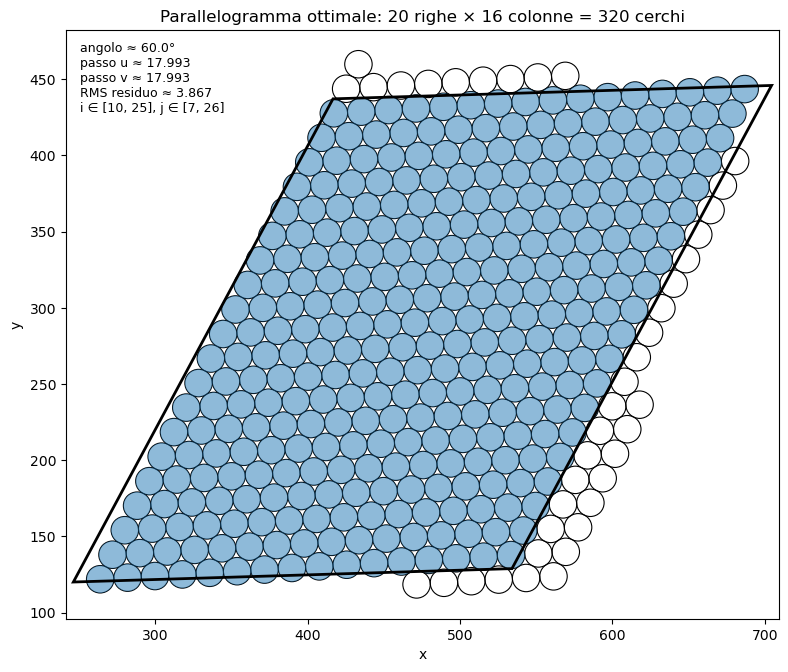

Row lengths (top→bottom):
  row  0: 20 cells
  row  1: 20 cells
  row  2: 20 cells
  row  3: 20 cells
  row  4: 20 cells
  row  5: 20 cells
  row  6: 20 cells
  row  7: 20 cells
  row  8: 20 cells
  row  9: 20 cells
  row 10: 20 cells
  row 11: 20 cells
  row 12: 20 cells
  row 13: 20 cells
  row 14: 20 cells
  row 15: 20 cells

Summary: #rows=16, min=20, max=20, unique=[20]
row0, remaining cells for each block:2, a:4, b:3
still space to place a=4 cells (remaining space=20)
cid:0, gid:0, current group:0
cid:1, gid:0, current group:0
cid:2, gid:0, current group:0
cid:3, gid:0, current group:0
4 cell placed (rem:16, n:1, cid:4)
still space to place b=3 cells (remaining space=16)
cid:4, gid:0, current group:1
cid:5, gid:0, current group:1
cid:6, gid:0, current group:1
3 cell placed (rem:13, n:2, cid:7)
row0, remaining cells for each block:2, a:4, b:3
still space to place a=4 cells (remaining space=13)
cid:7, gid:0, current group:2
cid:8, gid:0, current group:2
cid:9, gid:0, current group:

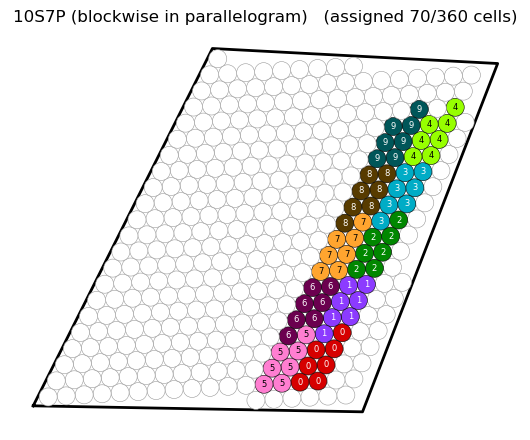

Series order: [9, 4, 3, 8, 7, 2, 1, 6, 5, 0]


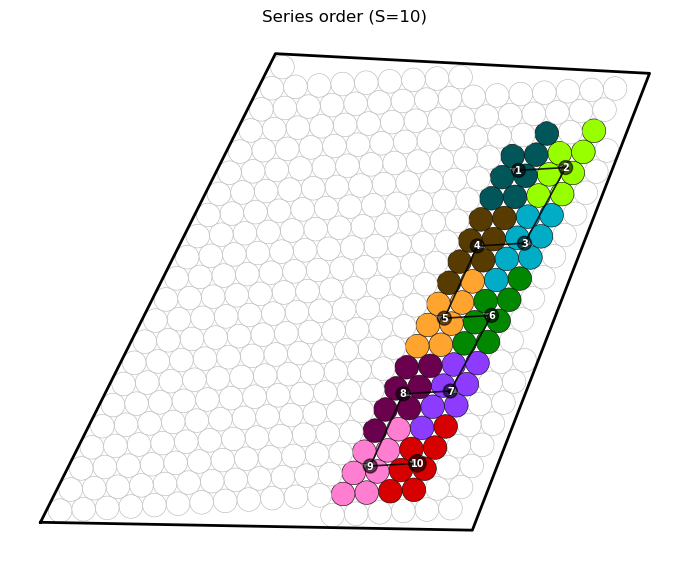

In [ ]:
# 1) find parallelogram
centres = gn.load_points("out.csv")
result  = gn.find_best_parallelogram_aligned(centres)
gn.plot_result(result, R)
poly, _ = cp.load_boundary(Path(json_file))

# 2) build rows from parallelogram
rows_inside = gn.rows_from_parallelogram(result)
rows_for_blockwise = rows_inside
if len(rows_inside) > len(rows_inside[0]):   # need vertical rows
    rows_for_blockwise = gn.columns_as_rows(rows_inside, centres, v=result['b'])

# ---- print row lengths (sanity) ---------------------------------------------
lengths = [len(r) for r in rows_for_blockwise]
print("Row lengths (top→bottom):")
for k, L in enumerate(lengths):
    print(f"  row {k:2d}: {L} cells")
print(f"\nSummary: #rows={len(rows_for_blockwise)}, "
      f"min={min(lengths)}, max={max(lengths)}, unique={sorted(set(lengths))}")

# ---- map GLOBAL -> LOCAL ids for the parallelogram --------------------------
selected_idx = result["selected_idx"]             # global ids in the parallelogram, in row-major order
orig2local   = {orig: i for i, orig in enumerate(selected_idx)}
rows_local   = [[orig2local[i] for i in row] for row in rows_for_blockwise]

# all rows must have equal width for the blockwise algorithm
assert len(set(len(r) for r in rows_local)) == 1, "Rows are not equal width"

# 3) run S×P blockwise only on the subgrid (LOCAL ids!)
S, P = 10, 7
part_of_local, groups_local = gn.group_xSyP_strict_reading(rows_local, S, P)

# 4) convert LOCAL -> GLOBAL ids for plotting/series step
part_of_global = { selected_idx[loc_id]: gid for loc_id, gid in part_of_local.items() }

# ---- plot blockwise result (white for unassigned) ---------------------------
full_part_of = {i: -1 for i in range(len(centres))}
full_part_of.update(part_of_global)

gn.plot_groups_blockwise(
    centres, full_part_of, poly,
    R=9.0, S=S, title=f"{S}S{P}P (blockwise in parallelogram)",
    show_labels=True, label_unassigned=False, fontsize=6
)

# 5) build contact graph ONLY on selected nodes and run series ordering
G_all = kg.build_contact_graph(centres)                # or build on all, once
sel_nodes = list(part_of_global.keys())
G_sub = G_all.subgraph(sel_nodes).copy()               # induced subgraph on used cells

# IMPORTANT: pass the reduced mapping (no -1 entries)
order, group_edges = so.series_order_ortools(G_sub, centres, part_of_global,
                                            beta=0.05, time_limit_s=5)
print("Series order:", order)

# plot series order (use part_of_global)
so.plot_series_order2(poly, centres, part_of_global, S, order, R=R)

In [ ]:
import series_ordering as so
import starting_k_grouping as kg


# ---- after you have the blockwise groups in the parallelogram ----
# part_of_sub : {cell_id -> group_id}    (ONLY ids inside the parallelogram)
# groups      : list of groups, len(groups) == S

S = len(groups)  # or: S = max(part_of_sub.values()) + 1

# 1) build contact graph on all cells
G_all = kg.build_contact_graph(centres)   # your function (uses R and EPS)

# 2) keep only the nodes used in the parallelogram
sel_nodes = list(part_of_sub.keys())          # cells we assigned
G_sub      = G_all.subgraph(sel_nodes).copy() # induced subgraph

# 3) run the series ordering **on the subgraph and the reduced mapping**
order, group_edges = series_order_ortools(G_sub, centres, part_of_sub,
                                          beta=0.05, time_limit_s=5)

print("Series order:", order)

# 4) plot (use the same reduced 'part_of_sub')
so.plot_series_order(poly, centres, part_of_sub, S, order, R=R)

In [ ]:
import prova_k_grouping as pkg
import random
S=25
P=11

# 1) Load & keep exactly S*P cells
centres_all = np.loadtxt("out.csv", delimiter=",", skiprows=1)
keep_mask   = kg.drop_periphery_iterative(centres_all, S*P)
centres     = centres_all[keep_mask]

# 2) Build anisotropic graph (row-friendly)
G = pkg.build_contact_graph_anisotropic(centres, R=R, eps=EPS, w_row=5.0, w_diag=2.0)


best_part = None
best_score = -1e18

rows = pkg.estimate_row_index(centres, R=R)

for run in range(8):  # 8–20 restarts helps a lot
    groups = list(G.nodes())
    random.shuffle(groups)
    kg.rb_exact_partition.gid_counter = 0
    part = kg.rb_exact_partition(G, groups, P)

    # (optional) quick refine with small weights
    part = pkg.refine_groups_regular(
        G, part, S, rows, centres,
        lam_iface=0.2, lam_perim=1.0,
        lam_rowvar=1.2, lam_rowspan=2.5,
        lam_xspan=0.5,
        max_rounds=30, verbose=False
    )

    sc = pkg.score_partition(
        G, part, S, rows, centres,
        lam_iface=0.3, lam_perim=1.6,
        lam_rowvar=2.0, lam_rowspan=3.0,
        lam_xspan=0.8
    )
    if sc > best_score:
        best_score = sc
        best_part  = part

part_of = best_part  # take the best one

group_color = kg.color_groups_avoiding_adjacent(G, part_of, S)


# ----- Sanity check -------------------------------------------------
#group_sizes = [parts.count(g) for g in range(S)]
#group_sizes = [list(part_of.values()).count(g) for g in range(S)]
#print("Group sizes:", group_sizes)        # should all be P

# ----- PLOT ---------------------------------------------------------
kg.plot_groups(poly, centres, part_of, S, group_color=group_color, title=f"S={S}, P={P} (adjacency-colored)")
# ----------------------------------------------------------------------

KeyboardInterrupt: 

In [ ]:
import prova_k_grouping as pkg
from claude import BatteryPackPartitioner
S=10
P=5

centres = centres_all.copy()
# identity map
global_ids_inside = np.arange(len(centres_all))

# 2) Build anisotropic graph (row-friendly)
G = pkg.build_contact_graph_anisotropic(centres, R=R, eps=EPS, w_row=5.0, w_diag=2.0)
#G = kg.build_contact_graph(centres)

bp = BatteryPackPartitioner(centres, radius=R, eps=EPS, seed=42)

# Weights (tune these to push more regular blocks vs. more interfaces)
weights = {
    'lam_cut':   6.0,
    'lam_perim': 1.6,
    'lam_rowvar': 1.0,
    'lam_rowspan': 0.8,
    'lam_nneigh': 1.2,
    'lam_maxiface': 0.2,
    'lam_xspan': 0.3,
}

result = bp.optimize(S, P, weights=weights, n_restarts=3000)  # try more restarts for better quality


part_of = {}
kept_nodes_local = result['kept_nodes']         # indices into bp.centres (which came from 'centres')
partition = result['partition']                 # group -> [node_ids in reindexed bp.graph]

# Map back: (group g -> local node u) -> original global id
for g, nodes in partition.items():
    for u in nodes:
        local_id = kept_nodes_local[u]          # index in 'centres'
        global_id = global_ids_inside[local_id] # index in 'centres_all'
        part_of[global_id] = g


bp.visualize(result)
bp.print_report(result)


VECCHIA VERSIONE

Kept 625 cells, discarded 95 extras


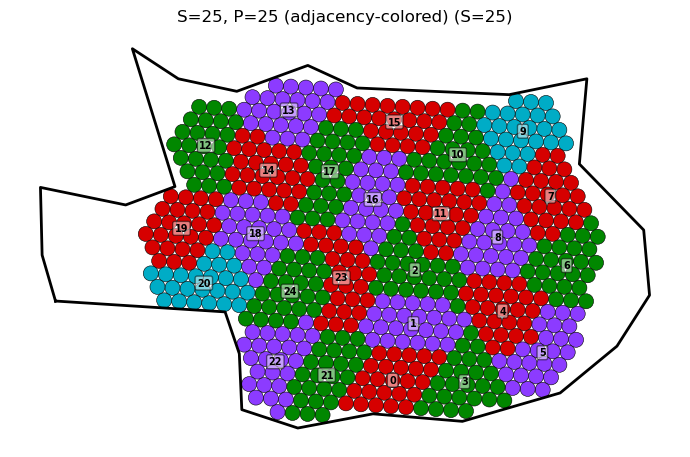

In [ ]:
S=25
P=25
centres_all = kg.load_centres(Path("out.csv"))
N_all = len(centres_all)

# ----- SELECT EXACTLY S*P CELLS ------------------------------------
keep_mask = kg.drop_periphery_iterative(centres_all, S*P)
centres   = centres_all[keep_mask]        # array of shape (S*P,2)
print(f"Kept {len(centres)} cells, discarded {N_all-len(centres)} extras")

# -------------------------------------------------------------------
G   = kg.build_contact_graph(centres)        # only those kept cells
#parts = metis_k_partition(G, S)           # S balanced parts
#parts = geodesic_capacity_partition(G, S, P)
#part_of = metis_connected_parts(G, S, P)   # healing on top of METIS

# parts is a list (len = S*P).  Convert to dict {node_id: group_id}
#part_dict = {i:part_of[i] for i in range(len(part_of))}
kg.rb_exact_partition.gid_counter = 0
part_of = kg.rb_exact_partition(G, list(G.nodes()), P)

group_color = kg.color_groups_avoiding_adjacent(G, part_of, S)


# ----- Sanity check -------------------------------------------------
#group_sizes = [parts.count(g) for g in range(S)]
#group_sizes = [list(part_of.values()).count(g) for g in range(S)]
#print("Group sizes:", group_sizes)        # should all be P

# ----- PLOT ---------------------------------------------------------
kg.plot_groups(poly, centres, part_of, S, group_color=group_color, title=f"S={S}, P={P} (adjacency-colored)")
# ----------------------------------------------------------------------



Series order: [13, 14, 12, 19, 20, 18, 24, 23, 16, 17, 15, 10, 9, 7, 6, 5, 4, 8, 11, 2, 1, 3, 0, 21, 22]
Polarity: {13: 1, 14: -1, 12: 1, 19: -1, 20: 1, 18: -1, 24: 1, 23: -1, 16: 1, 17: -1, 15: 1, 10: -1, 9: 1, 7: -1, 6: 1, 5: -1, 4: 1, 8: -1, 11: 1, 2: -1, 1: 1, 3: -1, 0: 1, 21: -1, 22: 1}


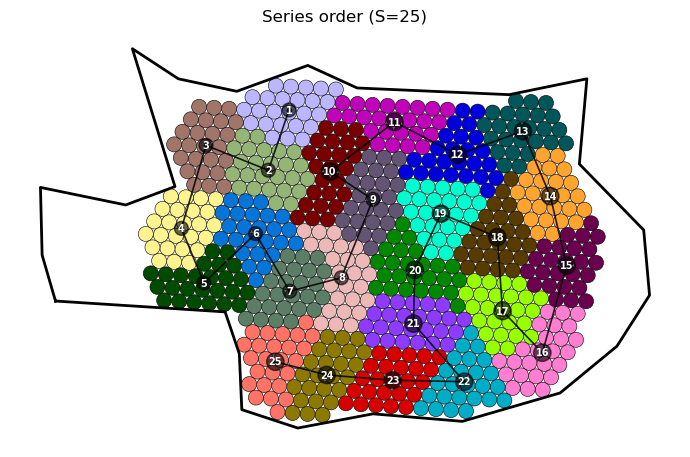

In [ ]:
import series_ordering as so

order, group_edges = so.series_order_ortools(G, centres, part_of, beta=0.05, time_limit_s=5)
print("Series order:", order)
# Optional polarity (+1, -1 alternating)
polarity = {g: (1 if i % 2 == 0 else -1) for i, g in enumerate(order)}
print("Polarity:", polarity)

# Plot
group_color = kg.color_groups_avoiding_adjacent(G, part_of, S)
so.plot_series_order(poly, centres, part_of, S, order, R=R)